<a href="https://colab.research.google.com/github/Amolmahale01/Amolmahale01/blob/main/Traffic_Prediction_Using_Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Traffic Prediction Using Machine Learning**
1. **Code Implementation**
*  Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import tensorflow
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from keras import callbacks
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

**Loading the Dataset**



In [2]:
dataset = pd.read_csv("traffic.csv")
dataset.head()

,DateTime,Junction,Vehicles,ID
0,2015-11-01 00:00:00,1,15,20151101001
1,2015-11-01 01:00:00,1,13,20151101011
2,2015-11-01 02:00:00,1,10,20151101021
3,2015-11-01 03:00:00,1,7,20151101031
4,2015-11-01 04:00:00,1,9,20151101041


Data Exploration


*   Feature engineering for EDA
*   Plotting time series
*   Parsing dates


In [4]:
dataset["DateTime"]= pd.to_datetime(dataset["DateTime"])
dataset = dataset.drop(["ID"], axis=1) #dropping IDs column
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48120 entries, 0 to 48119
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   DateTime  48120 non-null  datetime64[ns]
 1   Junction  48120 non-null  int64         
 2   Vehicles  48120 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 1.1 MB


Text(0.5, 0, 'Date')

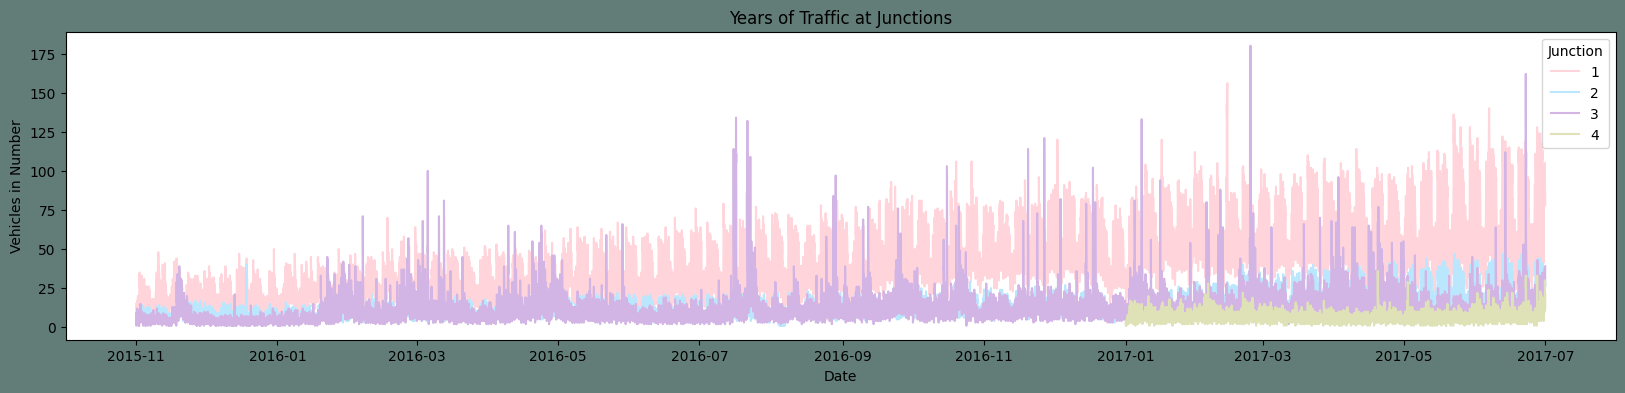

In [5]:
# dataframe to be used for EDA
dataframe=dataset.copy()

# Let's plot the Timeseries
colors = [ "#FFD4DB","#BBE7FE","#D3B5E5","#dfe2b6"]
plt.figure(figsize=(20,4),facecolor="#627D78")
Time_series=sns.lineplot(x=dataframe['DateTime'],y="Vehicles",data=dataframe, hue="Junction", palette=colors)
Time_series.set_title("Years of Traffic at Junctions")
Time_series.set_ylabel("Vehicles in Number")
Time_series.set_xlabel("Date")

In [6]:
# Exploring more features
dataframe["Year"]= dataframe['DateTime'].dt.year
dataframe["Month"]= dataframe['DateTime'].dt.month
dataframe["Date_no"]= dataframe['DateTime'].dt.day
dataframe["Hour"]= dataframe['DateTime'].dt.hour
dataframe["Day"]= dataframe.DateTime.dt.strftime("%A")
dataframe.head()

,DateTime,Junction,Vehicles,Year,Month,Date_no,Hour,Day
0,2015-11-01 00:00:00,1,15,2015,11,1,0,Sunday
1,2015-11-01 01:00:00,1,13,2015,11,1,1,Sunday
2,2015-11-01 02:00:00,1,10,2015,11,1,2,Sunday
3,2015-11-01 03:00:00,1,7,2015,11,1,3,Sunday
4,2015-11-01 04:00:00,1,9,2015,11,1,4,Sunday


**Exploratory Data Analysis**
*   The newly formed features are going to be plotted now.

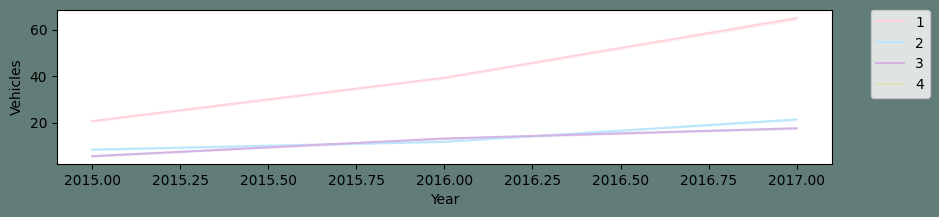

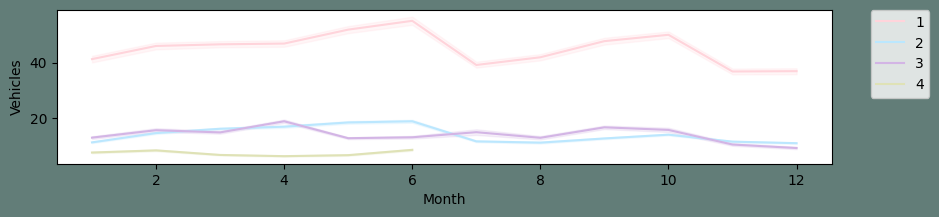

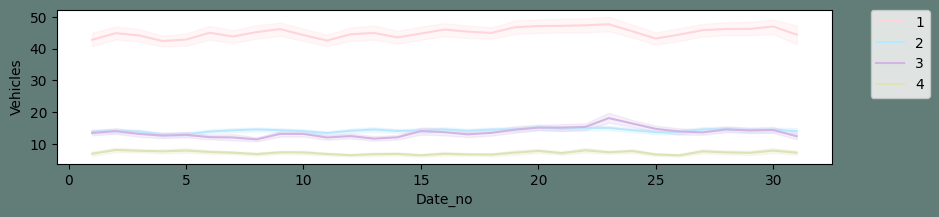

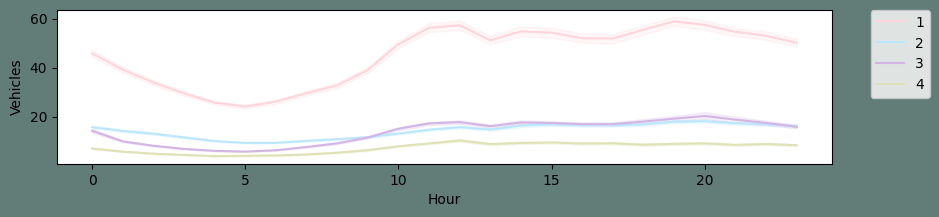

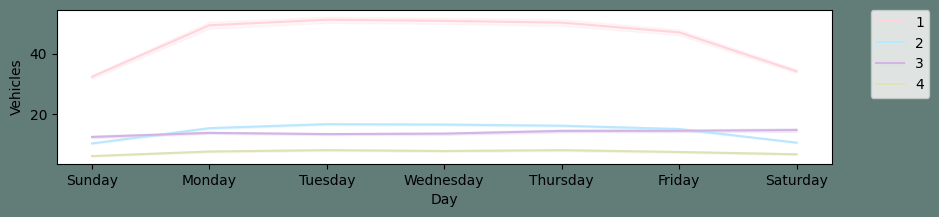

In [7]:
# Let's plot the Timeseries
new_features = [ "Year","Month", "Date_no", "Hour", "Day"]

for i in new_features:
    plt.figure(figsize=(10,2),facecolor="#627D78")
    ax=sns.lineplot(x=dataframe[i],y="Vehicles",data=dataframe, hue="Junction", palette=colors )
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

Text(0.5, 0, 'Date')

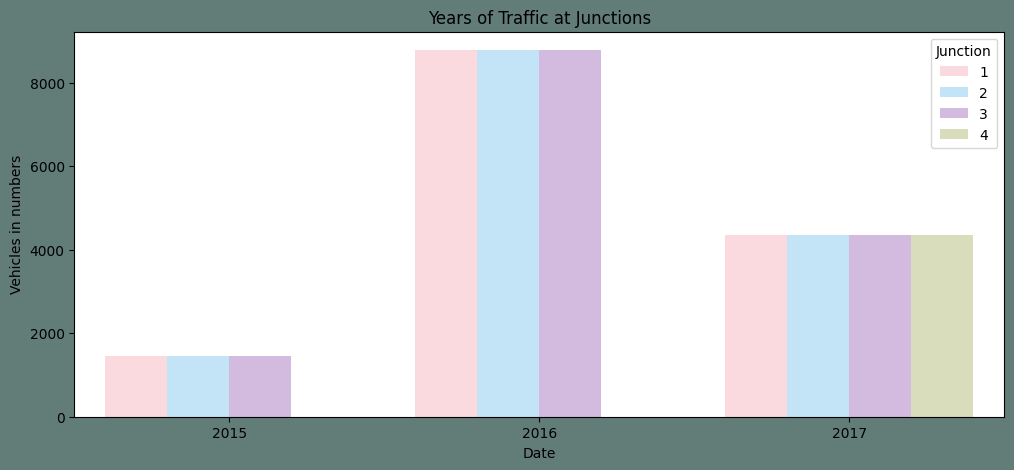

In [8]:
plt.figure(figsize=(12,5),facecolor="#627D78")
count = sns.countplot(data=dataframe, x =dataframe["Year"], hue="Junction", palette=colors)
count.set_title("Years of Traffic at Junctions")
count.set_ylabel("Vehicles in numbers")
count.set_xlabel("Date")

In [12]:
dataframe.drop('Day', axis=1, inplace=True)
corrmat = dataframe.corr()

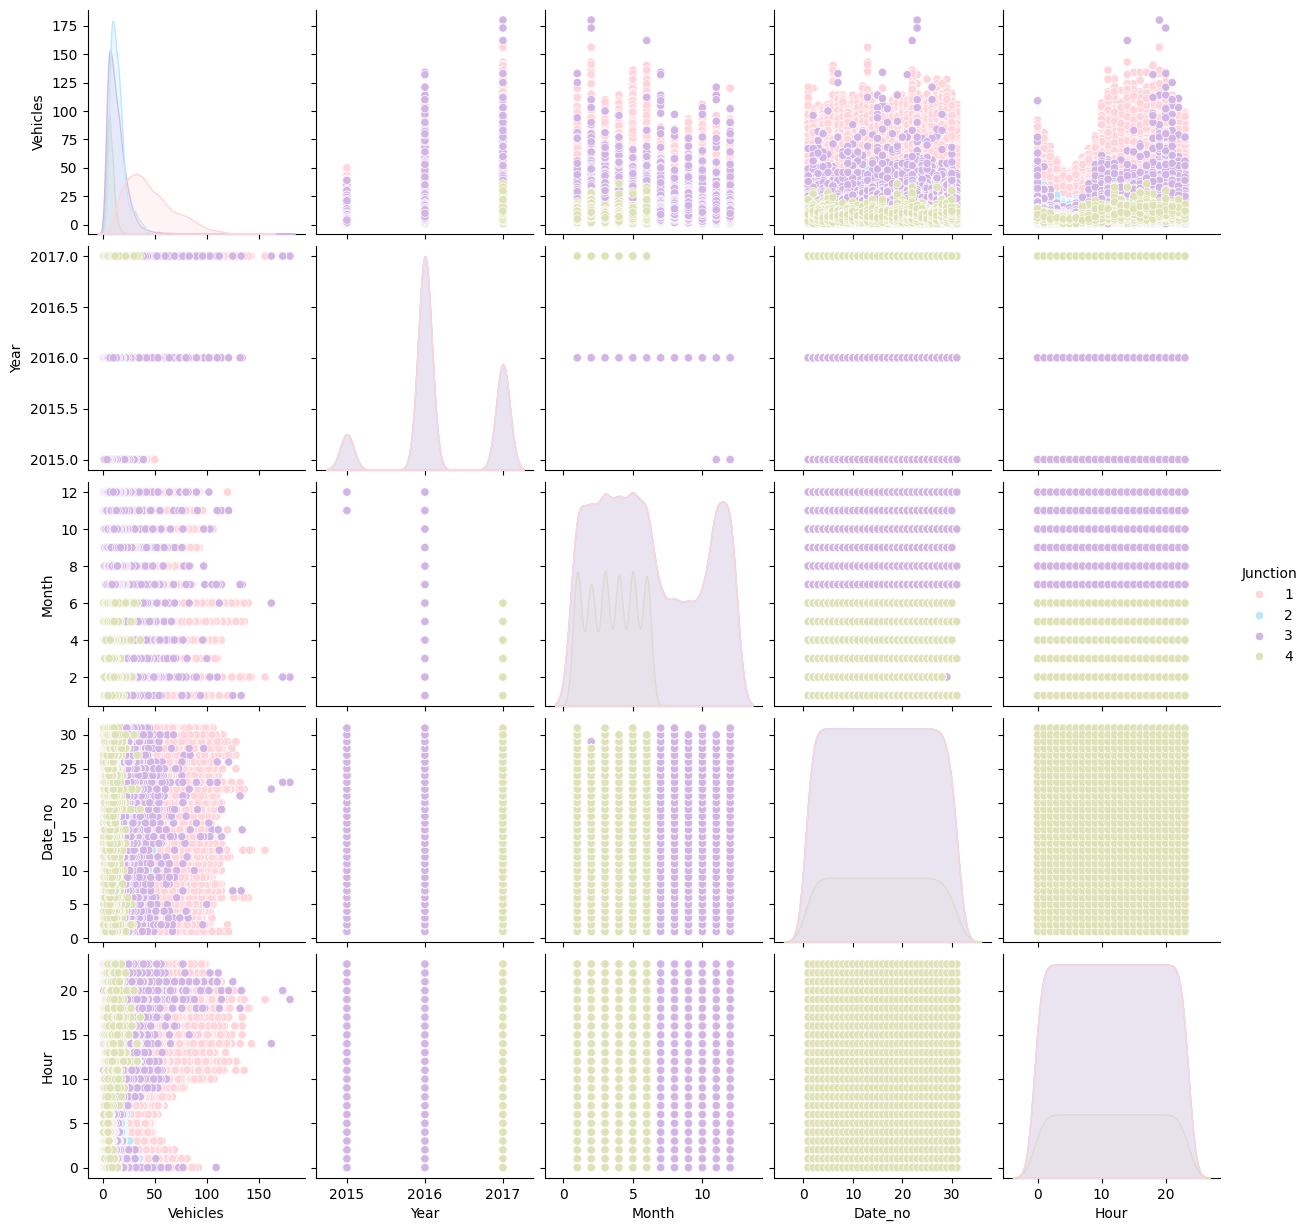

In [10]:
sns.pairplot(data=dataframe, hue= "Junction",palette=colors)

Data Transformation and Preprocessing
*    We shall proceed in the following order for this step:
1. At each junction, make unique frames and chart them
2. Plotting the series and changing it
3. Using the Augmented Dickey-Fuller test to determine if converted series are seasonal
4. Making training and test sets.

In [13]:
# Pivoting dataset from junction
dataframe_junction = dataset.pivot(columns="Junction", index="DateTime")
dataframe_junction.describe()

Vehicles                                         
Junction             1             2             3            4
count     14592.000000  14592.000000  14592.000000  4344.000000
mean         45.052906     14.253221     13.694010     7.251611
std          23.008345      7.401307     10.436005     3.521455
min           5.000000      1.000000      1.000000     1.000000
25%          27.000000      9.000000      7.000000     5.000000
50%          40.000000     13.000000     11.000000     7.000000
75%          59.000000     17.000000     18.000000     9.000000
max         156.000000     48.000000    180.000000    36.000000

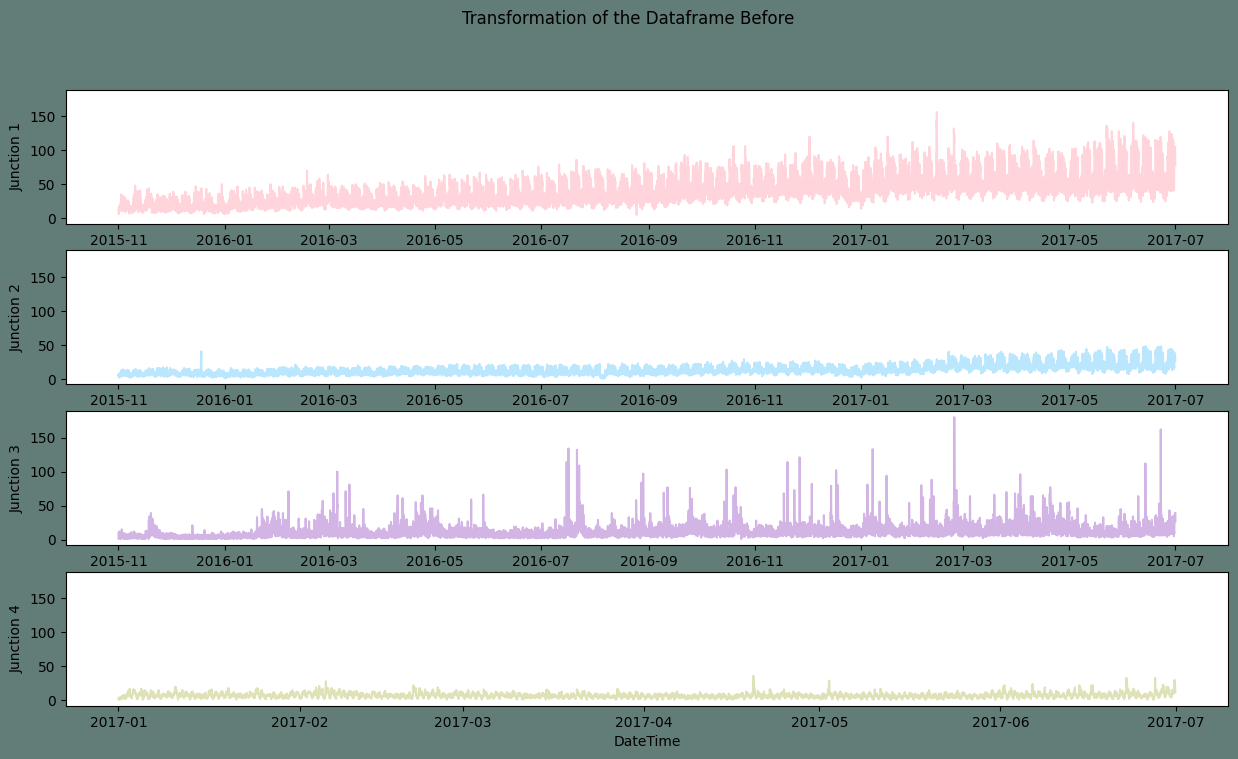

In [14]:
# Creating new dataframes
dataframe_1 = dataframe_junction[[('Vehicles', 1)]]
dataframe_2 = dataframe_junction[[('Vehicles', 2)]]
dataframe_3 = dataframe_junction[[('Vehicles', 3)]]
dataframe_4 = dataframe_junction[[('Vehicles', 4)]]
dataframe_4 = dataframe_4.dropna() #For only a few months, Junction 4 has only had minimal data.

# As DFS's data frame contains many indices, its index is lowering level one.
list_dfs = [dataframe_1, dataframe_2, dataframe_3, dataframe_4]
for i in list_dfs:
    i.columns= i.columns.droplevel(level=1)

# Creates comparison dataframe charts using this function
def Sub_Plots4(dataframe_1, dataframe_2,dataframe_3,dataframe_4,title):
    fig, axes = plt.subplots(4, 1, figsize=(15, 8),facecolor="#627D78", sharey=True)
    fig.suptitle(title)
    #J1
    pl_1=sns.lineplot(ax=axes[0],data=dataframe_1,color=colors[0])
    #pl_1=plt.ylabel()
    axes[0].set(ylabel ="Junction 1")
    #J2
    pl_2=sns.lineplot(ax=axes[1],data=dataframe_2,color=colors[1])
    axes[1].set(ylabel ="Junction 2")
    #J3
    pl_3=sns.lineplot(ax=axes[2],data=dataframe_3,color=colors[2])
    axes[2].set(ylabel ="Junction 3")
    #J4
    pl_4=sns.lineplot(ax=axes[3],data=dataframe_4,color=colors[3])
    axes[3].set(ylabel ="Junction 4")


# It is displayed to test for stationarity.
Sub_Plots4(dataframe_1.Vehicles, dataframe_2.Vehicles,dataframe_3.Vehicles,dataframe_4.Vehicles,"Transformation of the Dataframe Before")

In [15]:
# Normalize Function
def Normalize(dataframe,column):
    average = dataframe[column].mean()
    stdev = dataframe[column].std()
    df_normalized = (dataframe[column] - average) / stdev
    df_normalized = df_normalized.to_frame()
    return df_normalized, average, stdev

# Differencing Function
def Difference(dataframe,column, interval):
    diff = []
    for i in range(interval, len(dataframe)):
        value = dataframe[column][i] - dataframe[column][i - interval]
        diff.append(value)
    return diff

In [16]:
# In order to make the series stationary, normalize and differ
dataframe_N1, avg_J1, std_J1 = Normalize(dataframe_1, "Vehicles")
Diff_1 = Difference(dataframe_N1, column="Vehicles", interval=(24*7)) #taking a week's difference
dataframe_N1 = dataframe_N1[24*7:]
dataframe_N1.columns = ["Norm"]
dataframe_N1["Diff"]= Diff_1

dataframe_N2, avg_J2, std_J2 = Normalize(dataframe_2, "Vehicles")
Diff_2 = Difference(dataframe_N2, column="Vehicles", interval=(24)) #taking a day's difference
dataframe_N2 = dataframe_N2[24:]
dataframe_N2.columns = ["Norm"]
dataframe_N2["Diff"]= Diff_2

dataframe_N3, avg_J3, std_J3 = Normalize(dataframe_3, "Vehicles")
Diff_3 = Difference(dataframe_N3, column="Vehicles", interval=1) #taking an hour's difference
dataframe_N3 = dataframe_N3[1:]
dataframe_N3.columns = ["Norm"]
dataframe_N3["Diff"]= Diff_3

dataframe_N4, avg_J4, std_J4 = Normalize(dataframe_4, "Vehicles")
Diff_4 = Difference(dataframe_N4, column="Vehicles", interval=1) #taking an hour's difference
dataframe_N4 = dataframe_N4[1:]
dataframe_N4.columns = ["Norm"]
dataframe_N4["Diff"]= Diff_4

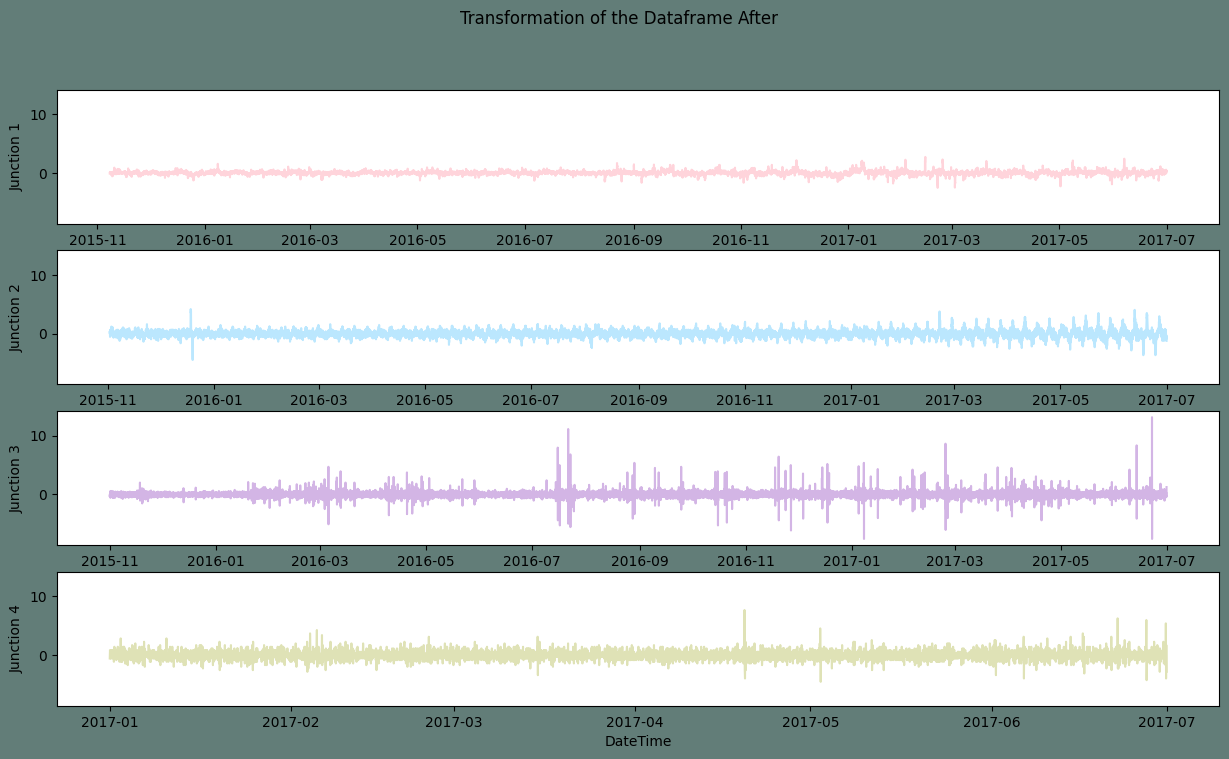

In [17]:
Sub_Plots4(dataframe_N1.Diff, dataframe_N2.Diff,dataframe_N3.Diff,dataframe_N4.Diff,"Transformation of the Dataframe After")

In [18]:
# Stationary time series check Improved Dickey-Fuller test
def Stationary_check(dataframe):
    check = adfuller(dataframe.dropna())
    print(f"ADF Statistic: {check[0]}")
    print(f"p-value: {check[1]}")
    print("Critical Values:")
    for key, value in check[4].items():
        print('\t%s: %.3f' % (key, value))
    if check[0] > check[4]["1%"]:
        print("Time Series is Non-Stationary")
    else:
        print("Time Series is Stationary")


# examining the series' stationary state

List_df_ND = [ dataframe_N1["Diff"], dataframe_N2["Diff"], dataframe_N3["Diff"], dataframe_N4["Diff"]]
print("Checking the transformed series for stationarity:")
for i in List_df_ND:
    print("\n")
    Stationary_check(i)

Checking the transformed series for stationarity:


ADF Statistic: -15.265303390415337
p-value: 4.79853987639816e-28
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Time Series is Stationary


ADF Statistic: -21.795891026940065
p-value: 0.0
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Time Series is Stationary


ADF Statistic: -28.001759908832316
p-value: 0.0
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Time Series is Stationary


ADF Statistic: -17.979092563052276
p-value: 2.778787532595421e-30
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Time Series is Stationary


In [19]:
# Several NA values were produced as a result of differencing using a week's worth of data.
dataframe_J1 = dataframe_N1["Diff"].dropna()
dataframe_J1 = dataframe_J1.to_frame()

dataframe_J2 = dataframe_N2["Diff"].dropna()
dataframe_J2 = dataframe_J2.to_frame()

dataframe_J3 = dataframe_N3["Diff"].dropna()
dataframe_J3 = dataframe_J3.to_frame()

dataframe_J4 = dataframe_N4["Diff"].dropna()
dataframe_J4 = dataframe_J4.to_frame()

# Splitting the dataset
def Split_data(dataframe):
    training_size = int(len(dataframe)*0.90)
    data_len = len(dataframe)
    train, test = dataframe[0:training_size],dataframe[training_size:data_len]
    train, test = train.values.reshape(-1, 1), test.values.reshape(-1, 1)
    return train, test
# Splitting the training and test datasets
Junction1_train, Junction1_test = Split_data(dataframe_J1)
Junction2_train, Junction2_test = Split_data(dataframe_J2)
Junction3_train, Junction3_test = Split_data(dataframe_J3)
Junction4_train, Junction4_test = Split_data(dataframe_J4)

# Target and Feature
def target_and_feature(dataframe):
    end_len = len(dataframe)
    X = []
    y = []
    steps = 32
    for i in range(steps, end_len):
        X.append(dataframe[i - steps:i, 0])
        y.append(dataframe[i, 0])
    X, y = np.array(X), np.array(y)
    return X ,y

# fixing the shape of X_test and X_train
def FeatureFixShape(train, test):
    train = np.reshape(train, (train.shape[0], train.shape[1], 1))
    test = np.reshape(test, (test.shape[0],test.shape[1],1))
    return train, test

# Assigning features and target
X_train_Junction1, y_train_Junction1 = target_and_feature(Junction1_train)
X_test_Junction1, y_test_Junction1 = target_and_feature(Junction1_test)
X_train_Junction1, X_test_Junction1 = FeatureFixShape(X_train_Junction1, X_test_Junction1)

X_train_Junction2, y_train_Junction2 = target_and_feature(Junction2_train)
X_test_Junction2, y_test_Junction2 = target_and_feature(Junction2_test)
X_train_Junction2, X_test_Junction2 = FeatureFixShape(X_train_Junction2, X_test_Junction2)

X_train_Junction3, y_train_Junction3 = target_and_feature(Junction3_train)
X_test_Junction3, y_test_Junction3 = target_and_feature(Junction3_test)
X_train_Junction3, X_test_Junction3 = FeatureFixShape(X_train_Junction3, X_test_Junction3)

X_train_Junction4, y_train_Junction4 = target_and_feature(Junction4_train)
x_test_Junction4, y_test_Junction4 = target_and_feature(Junction4_test)
X_train_Junction4, x_test_Junction4 = FeatureFixShape(X_train_Junction4, x_test_Junction4)

In [20]:
#Model for the prediction
def GRU_model(X_Train, y_Train, X_Test):
    early_stopping = callbacks.EarlyStopping(min_delta=0.001,patience=10, restore_best_weights=True)

    #The GRU model
    model = Sequential()
    model.add(GRU(units=150, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(GRU(units=150, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(GRU(units=50, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(GRU(units=50, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))

    model.add(GRU(units=50, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))

    # Compiling the model
    model.compile(optimizer=SGD(decay=1e-7, momentum=0.9),loss='mean_squared_error')
    model.fit(X_Train,y_Train, epochs=50, batch_size=150,callbacks=[early_stopping])
    pred_GRU= model.predict(X_Test)
    return pred_GRU

# To determine the root mean squared prediction error
def RMSE_Value(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))
    return rmse

# Plotting the goal and forecast comparison plot
def PredictionsPlot(test,predicted,m):
    plt.figure(figsize=(12,5),facecolor="#627D78")
    plt.plot(test, color=colors[m],label="True Value",alpha=0.5 )
    plt.plot(predicted, color="#627D78",label="Predicted Values")
    plt.title("GRU Traffic Prediction Vs True values")
    plt.xlabel("DateTime")
    plt.ylabel("Number of Vehicles")
    plt.legend()
    plt.show()

In [22]:
def GRU_model(X_Train, y_Train, X_Test):
    early_stopping = callbacks.EarlyStopping(min_delta=0.001,patience=10, restore_best_weights=True)

    #The GRU model
    model = Sequential()
    model.add(GRU(units=150, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(GRU(units=150, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(GRU(units=50, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(GRU(units=50, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))

    model.add(GRU(units=50, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))

    # Compiling the model
    model.compile(optimizer=SGD(learning_rate=1e-7, momentum=0.9),loss='mean_squared_error')
    model.fit(X_Train,y_Train, epochs=50, batch_size=150,callbacks=[early_stopping])
    pred_GRU= model.predict(X_Test)


In [25]:
# Ensure that X_test_Junction1 and y_train_Junction1 have the same number of samples
assert X_test_Junction1.shape[0] == y_train_Junction1.shape[0], "X_test_Junction1 and y_train_Junction1 must have the same number of samples."

# Call the GRU_model function with the correct arguments
PredJ1 = GRU_model(X_test_Junction1, y_train_Junction1, X_test_Junction1)

AssertionError: X_test_Junction1 and y_train_Junction1 must have the same number of samples.

In [26]:
#Predictions For Second Junction
PredJ2 = GRU_model(X_train_Junction2,y_test_Junction1,X_test_Junction2)

ValueError: Data cardinality is ambiguous:
  x sizes: 13079
  y sizes: 1411
Make sure all arrays contain the same number of samples.

In [ ]:
#Results for J2
RMSE_J2=RMSE_Value(y_test_Junction2,PredJ2)
PredictionsPlot(y_test_Junction2,PredJ2,1)

In [28]:
#Predictions For Third Junction
PredJ3 = GRU_model(X_train_Junction3,y_train_Junction3,X_test_Junction3)

Epoch 1/50
88/88 [==============================] - ETA: 0s - loss: 0.3046

88/88 [==============================] - 43s 379ms/step - loss: 0.3046
Epoch 2/50
88/88 [==============================] - ETA: 0s - loss: 0.3047

88/88 [==============================] - 32s 359ms/step - loss: 0.3047
Epoch 3/50
88/88 [==============================] - ETA: 0s - loss: 0.3047

88/88 [==============================] - 30s 341ms/step - loss: 0.3047
Epoch 4/50
88/88 [==============================] - ETA: 0s - loss: 0.3049

88/88 [==============================] - 32s 364ms/step - loss: 0.3049
Epoch 5/50
88/88 [==============================] - ETA: 0s - loss: 0.3046

88/88 [==============================] - 36s 405ms/step - loss: 0.3046
Epoch 6/50
88/88 [==============================] - ETA: 0s - loss: 0.3045

88/88 [==============================] - 31s 351ms/step - loss: 0.3045
Epoch 7/50
88/88 [==============================] - ETA: 0s - loss: 0.3046

88/88 [==============================] - 33s 380ms/step - loss: 0.3046
Epoch 8/50
88/88 [==============================] - ETA: 0s - loss: 0.3047

88/88 [==============================] - 33s 370ms/step - loss: 0.3047
Epoch 9/50
88/88 [==============================] - ETA: 0s - loss: 0.3047

88/88 [==============================] - 36s 406ms/step - loss: 0.3047
Epoch 10/50
88/88 [==============================] - ETA: 0s - loss: 0.3047

88/88 [==============================] - 39s 441ms/step - loss: 0.3047
Epoch 11/50
88/88 [==============================] - ETA: 0s - loss: 0.3049

88/88 [==============================] - 31s 351ms/step - loss: 0.3049
Epoch 12/50
88/88 [==============================] - ETA: 0s - loss: 0.3047

88/88 [==============================] - 31s 346ms/step - loss: 0.3047
Epoch 13/50
88/88 [==============================] - ETA: 0s - loss: 0.3045

88/88 [==============================] - 33s 376ms/step - loss: 0.3045
Epoch 14/50
88/88 [==============================] - ETA: 0s - loss: 0.3048

88/88 [==============================] - 32s 363ms/step - loss: 0.3048
Epoch 15/50
88/88 [==============================] - ETA: 0s - loss: 0.3047

88/88 [==============================] - 31s 350ms/step - loss: 0.3047
Epoch 16/50
88/88 [==============================] - ETA: 0s - loss: 0.3047

88/88 [==============================] - 30s 339ms/step - loss: 0.3047
Epoch 17/50
88/88 [==============================] - ETA: 0s - loss: 0.3047

88/88 [==============================] - 31s 349ms/step - loss: 0.3047
Epoch 18/50
88/88 [==============================] - ETA: 0s - loss: 0.3045

88/88 [==============================] - 35s 395ms/step - loss: 0.3045
Epoch 19/50
88/88 [==============================] - ETA: 0s - loss: 0.3048

88/88 [==============================] - 31s 358ms/step - loss: 0.3048
Epoch 20/50
88/88 [==============================] - ETA: 0s - loss: 0.3047

88/88 [==============================] - 30s 343ms/step - loss: 0.3047
Epoch 21/50
88/88 [==============================] - ETA: 0s - loss: 0.3048

88/88 [==============================] - 31s 349ms/step - loss: 0.3048
Epoch 22/50
88/88 [==============================] - ETA: 0s - loss: 0.3046

88/88 [==============================] - 32s 363ms/step - loss: 0.3046
Epoch 23/50
88/88 [==============================] - ETA: 0s - loss: 0.3048

88/88 [==============================] - 31s 347ms/step - loss: 0.3048
Epoch 24/50
88/88 [==============================] - ETA: 0s - loss: 0.3047

88/88 [==============================] - 30s 341ms/step - loss: 0.3047
Epoch 25/50
88/88 [==============================] - ETA: 0s - loss: 0.3047

88/88 [==============================] - 30s 340ms/step - loss: 0.3047
Epoch 26/50
88/88 [==============================] - ETA: 0s - loss: 0.3047

88/88 [==============================] - 31s 353ms/step - loss: 0.3047
Epoch 27/50
88/88 [==============================] - ETA: 0s - loss: 0.3047

88/88 [==============================] - 32s 367ms/step - loss: 0.3047
Epoch 28/50
88/88 [==============================] - ETA: 0s - loss: 0.3046

88/88 [==============================] - 30s 344ms/step - loss: 0.3046
Epoch 29/50
88/88 [==============================] - ETA: 0s - loss: 0.3045

88/88 [==============================] - 30s 342ms/step - loss: 0.3045
Epoch 30/50
88/88 [==============================] - ETA: 0s - loss: 0.3048

88/88 [==============================] - 31s 353ms/step - loss: 0.3048
Epoch 31/50
88/88 [==============================] - ETA: 0s - loss: 0.3048

88/88 [==============================] - 31s 346ms/step - loss: 0.3048
Epoch 32/50
88/88 [==============================] - ETA: 0s - loss: 0.3047

88/88 [==============================] - 30s 340ms/step - loss: 0.3047
Epoch 33/50
88/88 [==============================] - ETA: 0s - loss: 0.3048

88/88 [==============================] - 30s 339ms/step - loss: 0.3048
Epoch 34/50
88/88 [==============================] - ETA: 0s - loss: 0.3048

88/88 [==============================] - 30s 338ms/step - loss: 0.3048
Epoch 35/50
88/88 [==============================] - ETA: 0s - loss: 0.3049

88/88 [==============================] - 31s 348ms/step - loss: 0.3049
Epoch 36/50
88/88 [==============================] - ETA: 0s - loss: 0.3049

88/88 [==============================] - 32s 358ms/step - loss: 0.3049
Epoch 37/50
88/88 [==============================] - ETA: 0s - loss: 0.3047

88/88 [==============================] - 30s 339ms/step - loss: 0.3047
Epoch 38/50
88/88 [==============================] - ETA: 0s - loss: 0.3045

88/88 [==============================] - 30s 344ms/step - loss: 0.3045
Epoch 39/50
88/88 [==============================] - ETA: 0s - loss: 0.3048

88/88 [==============================] - 30s 343ms/step - loss: 0.3048
Epoch 40/50
88/88 [==============================] - ETA: 0s - loss: 0.3046

88/88 [==============================] - 30s 346ms/step - loss: 0.3046
Epoch 41/50
88/88 [==============================] - ETA: 0s - loss: 0.3047

88/88 [==============================] - 31s 347ms/step - loss: 0.3047
Epoch 42/50
88/88 [==============================] - ETA: 0s - loss: 0.3047

88/88 [==============================] - 30s 338ms/step - loss: 0.3047
Epoch 43/50
88/88 [==============================] - ETA: 0s - loss: 0.3047

88/88 [==============================] - 30s 338ms/step - loss: 0.3047
Epoch 44/50
88/88 [==============================] - ETA: 0s - loss: 0.3047

88/88 [==============================] - 30s 343ms/step - loss: 0.3047
Epoch 45/50
88/88 [==============================] - ETA: 0s - loss: 0.3046

88/88 [==============================] - 32s 361ms/step - loss: 0.3046
Epoch 46/50
88/88 [==============================] - ETA: 0s - loss: 0.3047

88/88 [==============================] - 32s 361ms/step - loss: 0.3047
Epoch 47/50
88/88 [==============================] - ETA: 0s - loss: 0.3046

88/88 [==============================] - 30s 344ms/step - loss: 0.3046
Epoch 48/50
88/88 [==============================] - ETA: 0s - loss: 0.3047

88/88 [==============================] - 30s 347ms/step - loss: 0.3047
Epoch 49/50
88/88 [==============================] - ETA: 0s - loss: 0.3048

88/88 [==============================] - 30s 346ms/step - loss: 0.3048
Epoch 50/50
88/88 [==============================] - ETA: 0s - loss: 0.3046

45/45 [==============================] - 4s 41ms/step


In [30]:
#Results for J3
RMSE_J3=RMSE_Value(y_test_Junction3,PredJ3)
PredictionsPlot(y_test_Junction3,PredJ3,2)

TypeError: Singleton array array(None, dtype=object) cannot be considered a valid collection.

In [31]:
#Predictions For Forth Junction
PredJ4 = GRU_model(X_train_Junction4,y_train_Junction4,x_test_Junction4)

Epoch 1/50
26/26 [==============================] - ETA: 0s - loss: 0.6901

26/26 [==============================] - 19s 365ms/step - loss: 0.6901
Epoch 2/50
26/26 [==============================] - ETA: 0s - loss: 0.6903

26/26 [==============================] - 10s 376ms/step - loss: 0.6903
Epoch 3/50
26/26 [==============================] - ETA: 0s - loss: 0.6901

26/26 [==============================] - 8s 303ms/step - loss: 0.6901
Epoch 4/50
26/26 [==============================] - ETA: 0s - loss: 0.6903

26/26 [==============================] - 10s 370ms/step - loss: 0.6903
Epoch 5/50
26/26 [==============================] - ETA: 0s - loss: 0.6904

26/26 [==============================] - 9s 365ms/step - loss: 0.6904
Epoch 6/50
26/26 [==============================] - ETA: 0s - loss: 0.6904

26/26 [==============================] - 10s 362ms/step - loss: 0.6904
Epoch 7/50
26/26 [==============================] - ETA: 0s - loss: 0.6902

26/26 [==============================] - 10s 376ms/step - loss: 0.6902
Epoch 8/50
26/26 [==============================] - ETA: 0s - loss: 0.6904

26/26 [==============================] - 10s 371ms/step - loss: 0.6904
Epoch 9/50
26/26 [==============================] - ETA: 0s - loss: 0.6901

26/26 [==============================] - 8s 302ms/step - loss: 0.6901
Epoch 10/50
26/26 [==============================] - ETA: 0s - loss: 0.6903

26/26 [==============================] - 10s 372ms/step - loss: 0.6903
Epoch 11/50
26/26 [==============================] - ETA: 0s - loss: 0.6901

26/26 [==============================] - 10s 372ms/step - loss: 0.6901
Epoch 12/50
26/26 [==============================] - ETA: 0s - loss: 0.6903

26/26 [==============================] - 8s 305ms/step - loss: 0.6903
Epoch 13/50
26/26 [==============================] - ETA: 0s - loss: 0.6902

26/26 [==============================] - 10s 370ms/step - loss: 0.6902
Epoch 14/50
26/26 [==============================] - ETA: 0s - loss: 0.6901

26/26 [==============================] - 10s 368ms/step - loss: 0.6901
Epoch 15/50
26/26 [==============================] - ETA: 0s - loss: 0.6899

26/26 [==============================] - 8s 305ms/step - loss: 0.6899
Epoch 16/50
26/26 [==============================] - ETA: 0s - loss: 0.6902

26/26 [==============================] - 10s 374ms/step - loss: 0.6902
Epoch 17/50
26/26 [==============================] - ETA: 0s - loss: 0.6902

26/26 [==============================] - 9s 352ms/step - loss: 0.6902
Epoch 18/50
26/26 [==============================] - ETA: 0s - loss: 0.6901

26/26 [==============================] - 8s 313ms/step - loss: 0.6901
Epoch 19/50
26/26 [==============================] - ETA: 0s - loss: 0.6903

26/26 [==============================] - 10s 377ms/step - loss: 0.6903
Epoch 20/50
26/26 [==============================] - ETA: 0s - loss: 0.6904

26/26 [==============================] - 9s 336ms/step - loss: 0.6904
Epoch 21/50
26/26 [==============================] - ETA: 0s - loss: 0.6904

26/26 [==============================] - 9s 334ms/step - loss: 0.6904
Epoch 22/50
26/26 [==============================] - ETA: 0s - loss: 0.6904

26/26 [==============================] - 9s 362ms/step - loss: 0.6904
Epoch 23/50
26/26 [==============================] - ETA: 0s - loss: 0.6904

26/26 [==============================] - 9s 336ms/step - loss: 0.6904
Epoch 24/50
26/26 [==============================] - ETA: 0s - loss: 0.6900

26/26 [==============================] - 9s 337ms/step - loss: 0.6900
Epoch 25/50
26/26 [==============================] - ETA: 0s - loss: 0.6902

26/26 [==============================] - 10s 371ms/step - loss: 0.6902
Epoch 26/50
26/26 [==============================] - ETA: 0s - loss: 0.6903

26/26 [==============================] - 8s 317ms/step - loss: 0.6903
Epoch 27/50
26/26 [==============================] - ETA: 0s - loss: 0.6901

26/26 [==============================] - 9s 343ms/step - loss: 0.6901
Epoch 28/50
26/26 [==============================] - ETA: 0s - loss: 0.6902

26/26 [==============================] - 10s 371ms/step - loss: 0.6902
Epoch 29/50
26/26 [==============================] - ETA: 0s - loss: 0.6903

26/26 [==============================] - 8s 302ms/step - loss: 0.6903
Epoch 30/50
26/26 [==============================] - ETA: 0s - loss: 0.6901

26/26 [==============================] - 10s 365ms/step - loss: 0.6901
Epoch 31/50
26/26 [==============================] - ETA: 0s - loss: 0.6904

26/26 [==============================] - 9s 366ms/step - loss: 0.6904
Epoch 32/50
26/26 [==============================] - ETA: 0s - loss: 0.6903

26/26 [==============================] - 8s 298ms/step - loss: 0.6903
Epoch 33/50
26/26 [==============================] - ETA: 0s - loss: 0.6902

26/26 [==============================] - 9s 364ms/step - loss: 0.6902
Epoch 34/50
26/26 [==============================] - ETA: 0s - loss: 0.6905

26/26 [==============================] - 10s 385ms/step - loss: 0.6905
Epoch 35/50
26/26 [==============================] - ETA: 0s - loss: 0.6902

26/26 [==============================] - 12s 470ms/step - loss: 0.6902
Epoch 36/50
26/26 [==============================] - ETA: 0s - loss: 0.6901

26/26 [==============================] - 13s 480ms/step - loss: 0.6901
Epoch 37/50
26/26 [==============================] - ETA: 0s - loss: 0.6902

26/26 [==============================] - 9s 335ms/step - loss: 0.6902
Epoch 38/50
26/26 [==============================] - ETA: 0s - loss: 0.6900

26/26 [==============================] - 12s 457ms/step - loss: 0.6900
Epoch 39/50
26/26 [==============================] - ETA: 0s - loss: 0.6904

26/26 [==============================] - 13s 507ms/step - loss: 0.6904
Epoch 40/50
26/26 [==============================] - ETA: 0s - loss: 0.6901

26/26 [==============================] - 13s 513ms/step - loss: 0.6901
Epoch 41/50
26/26 [==============================] - ETA: 0s - loss: 0.6904

26/26 [==============================] - 12s 466ms/step - loss: 0.6904
Epoch 42/50
26/26 [==============================] - ETA: 0s - loss: 0.6905

26/26 [==============================] - 8s 299ms/step - loss: 0.6905
Epoch 43/50
26/26 [==============================] - ETA: 0s - loss: 0.6902

26/26 [==============================] - 9s 356ms/step - loss: 0.6902
Epoch 44/50
26/26 [==============================] - ETA: 0s - loss: 0.6903

26/26 [==============================] - 9s 368ms/step - loss: 0.6903
Epoch 45/50
26/26 [==============================] - ETA: 0s - loss: 0.6901

26/26 [==============================] - 8s 301ms/step - loss: 0.6901
Epoch 46/50
26/26 [==============================] - ETA: 0s - loss: 0.6905

26/26 [==============================] - 10s 370ms/step - loss: 0.6905
Epoch 47/50
26/26 [==============================] - ETA: 0s - loss: 0.6902

26/26 [==============================] - 13s 506ms/step - loss: 0.6902
Epoch 48/50
26/26 [==============================] - ETA: 0s - loss: 0.6904

26/26 [==============================] - 13s 515ms/step - loss: 0.6904
Epoch 49/50
26/26 [==============================] - ETA: 0s - loss: 0.6902

26/26 [==============================] - 8s 301ms/step - loss: 0.6902
Epoch 50/50
26/26 [==============================] - ETA: 0s - loss: 0.6901

13/13 [==============================] - 2s 39ms/step


In [33]:
#Results for J4
RMSE_J4=RMSE_Value(y_test_Junction4,PredJ4)
PredictionsPlot(y_test_Junction4,PredJ4,3)

TypeError: Singleton array array(None, dtype=object) cannot be considered a valid collection.

In [34]:
# Set the data in lists to the initial error values of the four junctions.
Junctions = ["Junction1", "Junction2", "Junction3", "Junction4"]
RMSE = [RMSE_J1, RMSE_J2, RMSE_J3, RMSE_J4]
list_of_tuples = list(zip(Junctions, RMSE))
# Creates pandas DataFrame.
Results = pd.DataFrame(list_of_tuples, columns=["Junction", "RMSE"])
Results.style.background_gradient(cmap="Pastel1")

NameError: name 'RMSE_J1' is not defined

In [35]:
# Functions to inverse transforms and plot comparative plots
# invert differenced forecast
def inverse_difference(last_ob, value):
    inversed = value + last_ob
    return inversed

#Plotting the comparison
def Sub_Plots2(df_1, df_2,title,m):
    fig, axes = plt.subplots(1, 2, figsize=(18,4), sharey=True,facecolor="#627D78")
    fig.suptitle(title)

    pl_1=sns.lineplot(ax=axes[0],data=df_1,color=colors[m])
    axes[0].set(ylabel ="Prediction")

    pl_2=sns.lineplot(ax=axes[1],data=df_2["Vehicles"],color="#627D78")
    axes[1].set(ylabel ="Orignal")

In [36]:
# invert the differenced forecast for Junction 1
recover1 = dataframe_N1.Norm[-1412:-1].to_frame()
recover1["Pred"]= PredJ1
Transform_reverssed_J1 = inverse_difference(recover1.Norm, recover1.Pred).to_frame()
Transform_reverssed_J1.columns = ["Pred_Normed"]
#Invert the normalization J1
Final_J1_Pred = (Transform_reverssed_J1.values* std_J1) + avg_J1
Transform_reverssed_J1["Pred_Final"] =Final_J1_Pred
#Plotting the Predictions with originals
Sub_Plots2(Transform_reverssed_J1["Pred_Final"], dataframe_1[-1412:-1],"Pridictions And Orignals For Junction 1", 0)

NameError: name 'PredJ1' is not defined

In [37]:
#Invert the differenced J2
recover2 = dataframe_N2.Norm[-1426:-1].to_frame() #len as per the diff
recover2["Pred"]= PredJ2
Transform_reverssed_J2 = inverse_difference(recover2.Norm, recover2.Pred).to_frame()
Transform_reverssed_J2.columns = ["Pred_Normed"]
Final_J2_Pred = (Transform_reverssed_J2.values* std_J2) + avg_J2
Transform_reverssed_J2["Pred_Final"] =Final_J2_Pred
#Plotting the Predictions with originals
Sub_Plots2(Transform_reverssed_J2["Pred_Final"], dataframe_2[-1426:-1],"Pridictions And Orignals For Junction 2", 1)

NameError: name 'PredJ2' is not defined

In [38]:
#Invert the differenced J3
recover3 = dataframe_N3.Norm[-1429:-1].to_frame() #len as per the diff
recover3["Pred"]= PredJ3
Transform_reverssed_J3 = inverse_difference(recover3.Norm, recover3.Pred).to_frame()
Transform_reverssed_J3.columns = ["Pred_Normed"]
#Invert the normalization J3
Final_J3_Pred = (Transform_reverssed_J3.values* std_J3) + avg_J3
Transform_reverssed_J3["Pred_Final"] =Final_J3_Pred
Sub_Plots2(Transform_reverssed_J3["Pred_Final"], dataframe_3[-1429:-1],"Pridictions And Orignals For Junction 3", 2)

ValueError: 2

In [39]:
#Invert the differenced J4
recover4 = dataframe_N4.Norm[-404:-1].to_frame()  #len as per the test set
recover4["Pred"]= PredJ4
Transform_reverssed_J4 = inverse_difference(recover4.Norm, recover4.Pred).to_frame()
Transform_reverssed_J4.columns = ["Pred_Normed"]
#Invert the normalization J4
Final_J4_Pred = (Transform_reverssed_J4.values* std_J4) + avg_J4
Transform_reverssed_J4["Pred_Final"] =Final_J4_Pred
Sub_Plots2(Transform_reverssed_J4["Pred_Final"], dataframe_4[-404:-1],"Pridictions And Orignals For Junction 4", 3)

ValueError: 2